# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

# Quasi random sampling

TODO:
1. Study methods from the lib qmcpy
2. Sampling for pi estimate - write script to generate, and compute integral
    - golden ratio
    - Kronecker sequence
    - Halton sequence
3. Check eigenvalue influence - maybe comes up when generating sequences.


# Sequences - numerical approximation

We will generate a few sequences with low discrepancy for our estimations.

## Golden sequence
Coming from the golden ratio. The sequence is of the form
$$ x_{n} = \{n \alpha \}$$ where $ \{ n \alpha \} $ is the fractional part. \
$ \alpha $ is the solution of the equation $ z^{2} + z - 1 = 0 $. The number has a continued fraction expansion of form
$$
\alpha = \frac{1}{1 + \frac{1}{1 + \frac{1}{1 + \dots}}}
$$
We will estimate it using numerical approximation. Using mathematical induction, we start from $ x_{0} = 1$ then $ x_{n+1} = \frac{1}{1+x_{n}} $.

The following script estimates for the first 1000 numbers.


In [47]:
from typing import Generator, Sequence


def fraction_element(iterations: int = 1000, support_seq: Sequence[int] = (1,) ) -> Generator[float, None, None]:
    value = 0
    iteration = 0
    while iteration < iterations:
        try:
            item = support_seq[iteration]
        except IndexError:
            item = None
        support_seq_i = item if item else support_seq[-1]
        value = 1/(support_seq_i + value)
        yield value
        iteration += 1

def approximate_fraction(iterations: int = 1000, support_seq: Sequence[int] = (1,)) -> float:
    gen = fraction_element(iterations, support_seq)
    last_value = None
    for val in gen:
        last_value = val
    estimated = last_value
    return estimated

def approximate_golden_ratio(iterations: int = 1000) -> float:
    return approximate_fraction(iterations)

alpha = approximate_golden_ratio()

print("Approximated alpha =", alpha)

Approximated alpha = 0.6180339887498948


## Kronecker sequence $\beta$ estimation

The sequence is of the form
$$ x_{n} = \{n \beta \}$$ where $ \{n \beta \}$ is the fractional part. \
Now let's estimate a $ \beta $ for a kronecker sequence estimation. We will use the fraction expansion estimation.

In [48]:
import random
def generate_bounded_sequence(n: int, bound: int) -> Generator[int, None, None]:
    for _ in range(n):
        yield random.randint(0, bound)

def approximate_kronecker_beta(iterations: int = 1000) -> float:
    seq_tuple = tuple(generate_bounded_sequence(iterations, bound= 10))
    return approximate_fraction(iterations= iterations, support_seq = seq_tuple)

beta = approximate_kronecker_beta()
print( "Approximated beta =", beta)

Approximated beta = 0.12021509450193171


## Sequence generation
Now we can use these values to generate a golden sequence and a sample kronecker sequence. We will visualize the results.

### Golden sequence
$$ x_{n} = \{n \alpha \}$$

First 20 elements for our approximated alpha:  0.6180339887498948
0.0
0.6180339887498948
0.23606797749978958
0.8541019662496843
0.47213595499957917
0.09016994374947407
0.7082039324993685
0.32623792124926343
0.9442719099991583
0.5623058987490532
0.18033988749894814
0.798373876248843
0.41640786499873705
0.034441853748631956
0.6524758424985269
0.27050983124842176
0.8885438199983167
0.5065778087482116
0.12461179749810647
0.7426457862480014


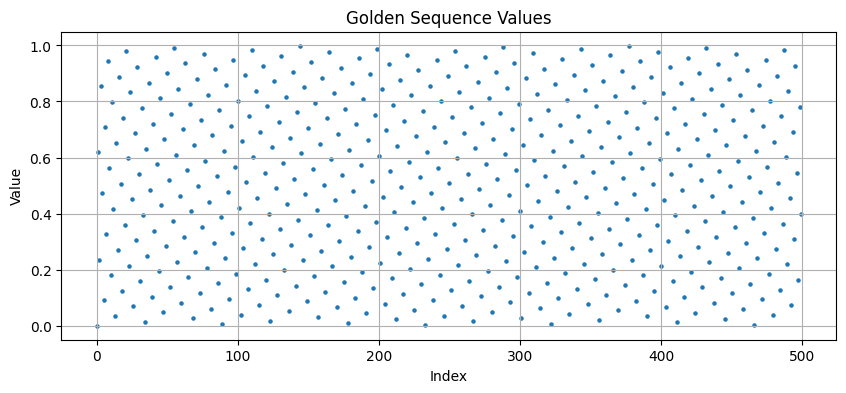

In [49]:
from plotting import plot_sequence
from typing import Callable

def sequence(value_func: Callable[[int], float]) -> Generator[float, None, None]:
    i = 0
    while True:
        yield value_func(i)
        i += 1

def golden_sequence(dimension: int = 1) -> Generator[float, None, None]:
    while True:
        yield from sequence(lambda n: (n * alpha**dimension) % 1)


print("First 20 elements for our approximated alpha: ", alpha)
for _, val_i in zip(range(20), golden_sequence()):
    print( val_i, end='\n')

plot_sequence(golden_sequence(), title =  "Golden Sequence Values")

## Kronecker sequence

$$ x_{n} = \{n \beta \}$$


First 20 elements for our approximated beta:  0.12021509450193171
0.0
0.12021509450193171
0.24043018900386343
0.36064528350579517
0.48086037800772685
0.6010754725096585
0.7212905670115903
0.841505661513522
0.9617207560154537
0.0819358505173855
0.20215094501931707
0.32236603952124887
0.44258113402318067
0.5627962285251122
0.683011323027044
0.8032264175289756
0.9234415120309074
0.04365660653283898
0.163871701034771
0.2840867955367026


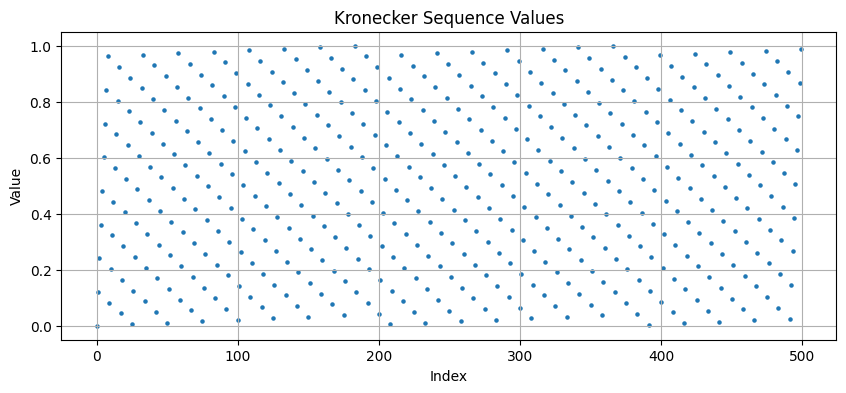

In [50]:
def kronecker_sequence(dimension: int = 1) -> Generator[float, None, None]:
    while True:
        yield from sequence(lambda n: (n * beta**dimension) % 1)


print("First 20 elements for our approximated beta: ", beta)
for _, val_i in zip(range(20), kronecker_sequence()):
    print( val_i, end='\n')

from plotting import plot_sequence
plot_sequence(kronecker_sequence(), title = "Kronecker Sequence Values")

## Plotting results
As we can see both of these sequences seems pretty "regular". They are far off from a regular PRNG results plot. Let's compare with python standard library Mersenne Twister.


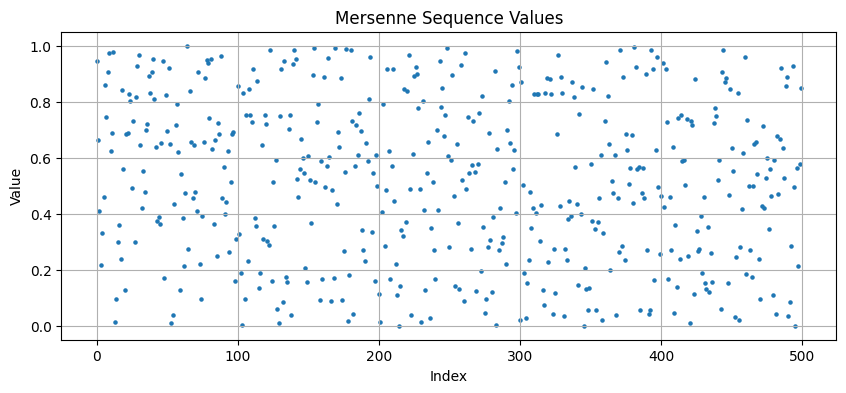

In [51]:
from typing import Generator
import random

def mersenne_sequence(seed: int = None) -> Generator[float, None, None]:
    """
    Infinite generator yielding floats in [0,1) using Mersenne Twister (random.random).

    Args:
        seed: Optional seed for reproducibility
    """
    rng = random.Random(seed)  # create an independent RNG
    while True:
        yield rng.random()       # random() uses Mersenne Twister

from plotting import plot_sequence
plot_sequence(mersenne_sequence(), title = "Mersenne Sequence Values")


# Quasi-random estimation

We will now use the generated sequences to estimate pi. Let's generate points $x_{i} \in U(0,1)^{2}$. Then we will estimate how many of these are inside the unit circle using $$
Y_{j} = 4 \mathbf{1}\!\left( x^{2}_{i,1} + x^{2}_{i,2} \leq 1 \right)
$$
Then we can estimate $\Pi$ by calculating the mean $$ \frac{1}{N} \Sigma_{j \leq N} Y_{j}$$

Since our quasi random sequences aren't random at all we obviously need to modify the n-dimensional sequence somehow, otherwise we would end up with diagonal points only. Because of this we will use n-th power of $\alpha$ and $\beta$ respectively. These are still low discrepancy sequences and not linearly dependant on each other. So our sequences will be of the form:
1. Golden sequence derived: $(x_{i},y_{i}) = \{\alpha n\}, (\{ \alpha^{2} n \}) \in [0,1)^{2}$
2. Kronecker derived: $(x_{i},y_{i}) = (\{ \beta n \}, \{ \beta^{2} n \}) \in [0,1)^{2}$

TODO: show alpha^n is low discrepancy



In [52]:
def estimate_pi(x_vals: Sequence[float], y_vals: Sequence[float]) -> float:
    if len(x_vals) != len(y_vals):
        raise ValueError("X and Y sequences must have same length. Got x length: ", len(x_vals), "y length: ", len(y_vals))
    seq_size = len(x_vals)
    in_circle = lambda x,y: x**2 + y**2 <= 1
    circle_points = tuple(in_circle(x,y) for x,y in zip(x_vals, y_vals))
    return 4*sum(circle_points)/seq_size


## Sampling $\Pi$ using Mersenne-Twister
First we will estimate using the standard Mersenne-twister generator.


In [53]:
from matplotlib import pyplot as plt
from plotting import default_scatter_plot, add_quarter_circle
import time
def pi_estimation(gen_x: Generator[float, None], gen_y: Generator[float, None], gen_name: str, n: int = 2000):
    start_time = time.time()

    ax = tuple(next(gen_x) for _ in range(n))
    ay = tuple(next(gen_y) for _ in range(n))

    pi = estimate_pi(ax, ay)
    print(f"{gen_name} pi estimation: ", pi, "iterations: ", n)

    end_time = time.time()  # record end
    print(f"Execution time: {end_time - start_time:.4f} seconds")

    axes = default_scatter_plot(ax, ay, f"{gen_name} Sequence sampling in 2D")
    add_quarter_circle(axes)
    plt.show()

    return pi, end_time

Mersenne Twister pi estimation:  3.13 iterations:  2000
Execution time: 0.0010 seconds


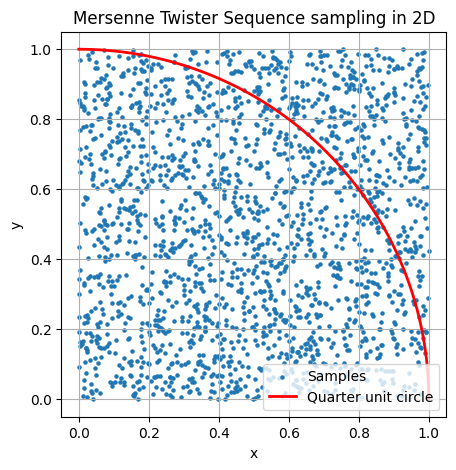

Mersenne Twister pi estimation:  3.139 iterations:  20000
Execution time: 0.0107 seconds


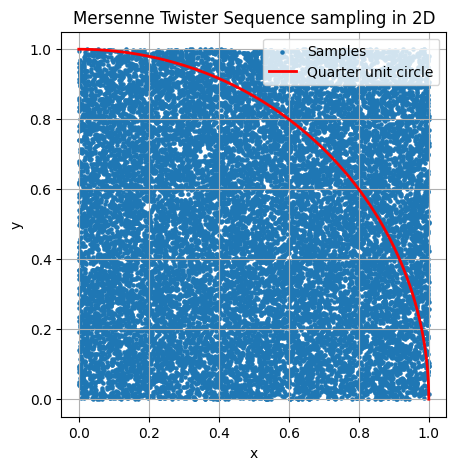

In [54]:
pi_estimation(
    gen_x = mersenne_sequence(23),
    gen_y = mersenne_sequence(45),
    gen_name= "Mersenne Twister",
    n=2000,)


mersenne_pi, mersenne_time = pi_estimation(
    gen_x = mersenne_sequence(23),
    gen_y = mersenne_sequence(45),
    gen_name= "Mersenne Twister",
    n=20000,)

We get around 3.13 with only 2000 numbers and 0.0018 secs, but for 20000 numbers we only get 3.139 in 0.0086 secs. The estimation doesnt improve too much.

## Sampling $\Pi$ using Golden sequence


Golden Sequence pi estimation:  3.166 iterations:  2000
Execution time: 0.0014 seconds


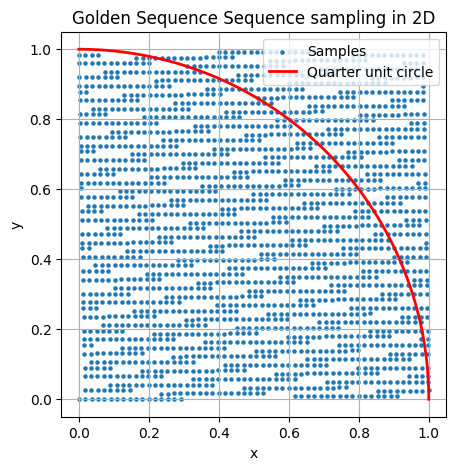

Golden Sequence pi estimation:  3.1432 iterations:  20000
Execution time: 0.0135 seconds


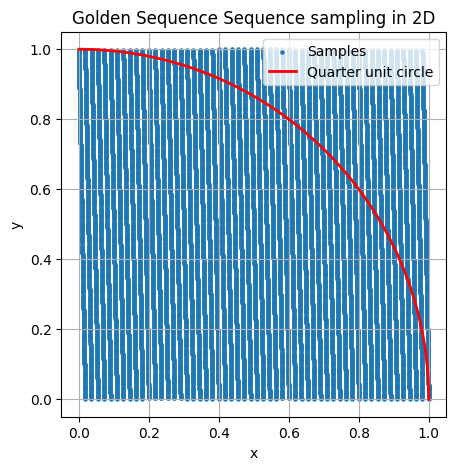

In [55]:
gen_x = golden_sequence(1)
gen_y = golden_sequence(10)
pi_estimation(gen_x, gen_y, gen_name="Golden Sequence", n = 2000)
golden_pi, golden_time = pi_estimation(gen_x, gen_y, gen_name="Golden Sequence", n = 20000)

For golden sequence we get a pretty uninspiring 3.166 at 2,000 iterations, but at 20,000 we get 3.1432 which is much closer by at least one decimal than the mersenne-twister approach. Execution time is slower than mersenne about 0.01s.

## Sampling $\Pi$ using Kronecker sequence

Kronecker Sequence pi estimation:  3.996 iterations:  2000
Execution time: 0.0014 seconds


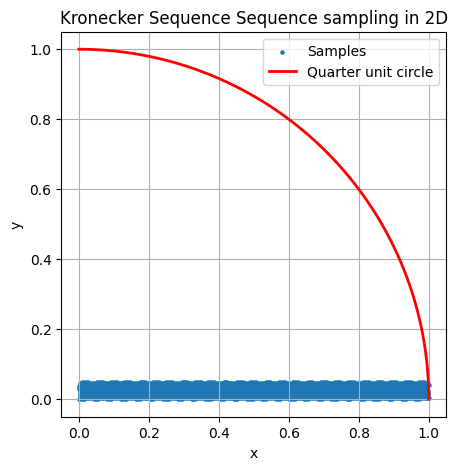

Kronecker Sequence pi estimation:  3.765 iterations:  20000
Execution time: 0.0132 seconds


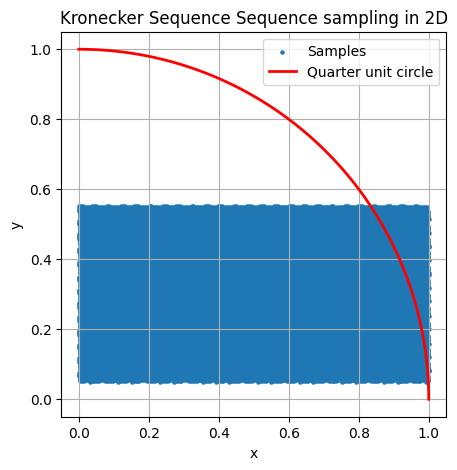

In [56]:
gen_x = kronecker_sequence(1)
gen_y = kronecker_sequence(5)
pi_estimation(gen_x, gen_y, gen_name="Kronecker Sequence", n = 2000)
kronecker_pi, kronecker_time = pi_estimation(gen_x, gen_y, gen_name="Kronecker Sequence", n = 20000)

For kronecker we also get much closer with 20,000 iterations but time is slower by about 0.01s.

## Custom Mersenne comparison
The random.Random function is written in C and heavily optimized. Let's use a custom MT implementation written purely in python to compare.

Python Mersenne Twister pi estimation:  3.164 iterations:  2000
Execution time: 0.0068 seconds


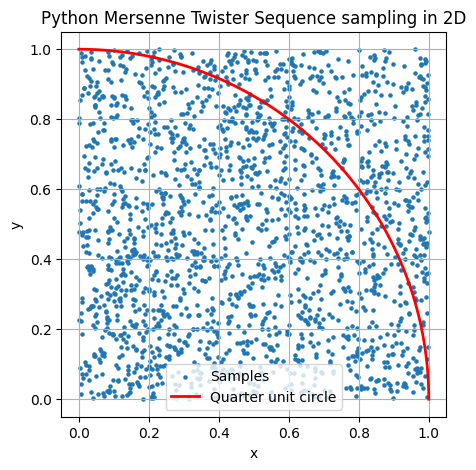

Python Mersenne Twister pi estimation:  3.1566 iterations:  20000
Execution time: 0.0501 seconds


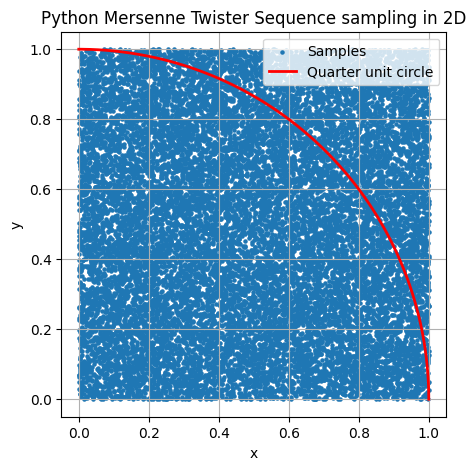

In [57]:
from MT_custom import MT19937
def custom_twister_sequence(seed: int = 42) -> Generator[float, None, None]:
    rng = MT19937(seed)
    while True:
        yield rng.random()

pi_estimation(
    gen_x = custom_twister_sequence(23),
    gen_y = custom_twister_sequence(45),
    gen_name= "Python Mersenne Twister",
    n=2000,)


custom_mersenne_pi, custom_mersenne_time = pi_estimation(
    gen_x = custom_twister_sequence(23),
    gen_y = custom_twister_sequence(45),
    gen_name= "Python Mersenne Twister",
    n=20000,)


As expected this is 5 times slower and still similar precision to the Cython Mersenne. This proves numerically that quasi random numbers converge in absolute numbers and take less time per number to generate.